In [68]:
! pip install qiskit qiskit-ibm-runtime rustworkx scipy typing black tqdm pygraphviz pylint qiskit-algorithms tqdm

DEPRECATION: Loading egg at /media/sayan/user_data/Documents/iitd_resources/Fourth/COL861/assignments/.venv/lib/python3.12/site-packages/subgraph_isomorphism-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /media/sayan/user_data/Documents/iitd_resources/Fourth/COL861/assignments/.venv/lib/python3.12/site-packages/tqdm-4.67.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /media/sayan/user_data/Documents/iitd_resources/Fourth/COL861/assignments/.venv/lib/python3.12/site-packages/pygraphviz-1.14-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for packa

# Import statements

In [13]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
#from qiskit_ibm_runtime.fake_provider import FakeKyiv
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator, QiskitRuntimeService
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from typing import Sequence

In [50]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""Implementation of the functions for the construction of the Quantum Subgraph Isomorphism
algorithm."""

from itertools import chain
from typing import Union, Tuple
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import Diagonal


IntOrTuple = Union[int, Tuple]


def _hcph(phi: float, qc: QuantumCircuit, qubits: IntOrTuple):
    ctrl, target = qubits if isinstance(qubits, tuple) else (-1, qubits)
    qc.h(target)
    if ctrl >= 0:
        qc.cp(phi, ctrl, target)
    else:
        qc.p(phi, target)
    qc.h(target)


S4_BLOCK_PARCOUNT = 5


def _s4_block(params: np.ndarray) -> QuantumCircuit:
    """Build the basic block S4 for the permutations Ansatz.

    Args:
        params (np.ndarray): The array of parameters.
    """
    params = np.asarray(params).flatten()
    assert params.shape == (S4_BLOCK_PARCOUNT,)
    qc = QuantumCircuit(QuantumRegister(name="q", size=2))
    _hcph(params[0], qc, 0)

    qc.h(1)
    qc.p(params[1], 1)
    qc.cp(params[2], 0, 1)
    qc.h(1)

    _hcph(params[3], qc, (1, 0))
    _hcph(params[4], qc, (0, 1))
    return qc


def _map_qreg(array, qreg: QuantumRegister) -> np.ndarray:
    assert isinstance(qreg, QuantumRegister)
    array = np.asarray(array)
    fun = np.vectorize(lambda i: qreg[i])
    return fun(array)


def _expand_topology(topology, *, qreg: QuantumRegister) -> np.ndarray:
    if isinstance(topology, str):
        if topology in {"linear", "circular"}:
            v = np.arange(qreg.size - 1)
            v = np.stack([v, v + 1]).T
            if topology == "circular" and qreg.size > 2:
                v = np.concatenate([v, np.array([[qreg.size - 1, 0]])], axis=0)
            topology = v
        else:
            raise ValueError(f"Unrecognized topology: {topology}")
    topology = np.asarray(topology)
    assert topology.ndim == 2 and topology.shape[1] == 2
    return _map_qreg(topology, qreg=qreg)


def s4_ansatz(
    topology, *, qreg: Union[QuantumRegister, int], params=None
) -> Tuple[QuantumCircuit, np.ndarray]:
    """Construct the permutations ansatz based on the S4 block.

    Args:
        topology (str, np.ndarray): The topology for the ansatz, see the function
        ansatz() for more information.
        qreg (QuantumRegister, int): The destination quantum register.
        params (np.ndarray): The array of parameters.
    """
    if isinstance(qreg, int):
        qreg = QuantumRegister(qreg)
    assert isinstance(qreg, QuantumRegister)
    topology = _expand_topology(topology, qreg=qreg)
    if params is None:
        params = params_tensor((len(topology), S4_BLOCK_PARCOUNT))
    params = np.asarray(params)
    assert params.ndim == 2 and params.shape[1] == S4_BLOCK_PARCOUNT
    assert len(params) == len(topology)
    qc = QuantumCircuit(qreg)
    for v, q in zip(params, topology):
        qc.compose(_s4_block(v), qubits=q, inplace=True)

    qc_ = QuantumCircuit(qreg)
    qc_.compose(qc.to_gate(label="PermAnsatz"), inplace=True)
    return qc_, params


def params_tensor(shape, *, name="t") -> np.ndarray:
    """Prepare a tensor of circuit parameters."""
    shape = tuple(np.atleast_1d(shape).flatten())
    v = ParameterVector(name=name, length=np.prod(shape))
    v = np.array(v.params, dtype=object)
    return v.reshape(shape)


# def observable(n: int) -> SparsePauliOp:
#     """Prepare the observable for the VQE Framework."""
#     obs0 = SparsePauliOp.from_list([("Z", 1), ("I", 1)]) / 2
#     return -(obs0.tensorpower(n))


def observable(n: int) -> SparsePauliOp:
    """Prepare the observable for the VQE Framework.
    
    The observable is defined as the negative tensor product of n copies of |0⟩⟨0|.
    Note: |0⟩⟨0| can be expressed as (I + Z)/2.
    """
    # Define the single-qubit projector onto |0⟩: (I + Z) / 2
    single_proj = SparsePauliOp.from_list([("I", 0.5), ("Z", 0.5)])
    
    # Build the n-qubit operator via tensor product
    obs = single_proj
    for _ in range(n - 1):
        obs = obs.tensor(single_proj)
    
    return -obs

def _is_pow_2(v: int):
    assert isinstance(v, int)
    return (bin(v).count("1") == 1) or (v == 0)


def _pow2_shaped_mat_validation(mat):
    mat = np.asarray(mat)
    assert mat.ndim == 2
    assert mat.shape[0] == mat.shape[1]
    assert all(map(_is_pow_2, mat.shape))
    return mat


def _circ_qregs(n: int, *, as_qubits=False):
    assert (n + 1) % 2 == 0
    m = (n - 1) // 2
    regs_config = zip((m, m, 1), ("i", "j", "a"))
    ret = tuple(QuantumRegister(sz, name=name) for sz, name in regs_config)
    return tuple(chain(*ret)) if as_qubits else ret


def _adj_flatten_repr(adj: np.ndarray, *, shape=None) -> QuantumCircuit:
    """Produce the quantum circuit that represents the given
    adjacency matrix in flattened form as diagonal operator.

    Args:
        adj: The input adjacency matrix.
        shape: Optional shape for the input matrix. When not None
        the input matrix is zero-padded extended to this shape.
    """
    adj = np.round(adj) != 0
    assert adj.ndim == 2 and adj.shape[0] == adj.shape[1]
    adj = adj if shape is None else _mat_zero_ext(adj, shape=shape)
    assert _is_pow_2(len(adj))
    adj = adj.flatten()
    adj = np.concatenate([np.zeros_like(adj), adj])
    adj = np.exp(1j * adj * np.pi)
    adj = Diagonal(adj)
    qc = QuantumCircuit(*_circ_qregs(adj.num_qubits))
    qc = qc.compose(
        adj.to_gate(label="QAdj"), qubits=_circ_qregs(adj.num_qubits, as_qubits=True)
    )
    return qc


def _mat_zero_ext(mat, *, shape):
    mat = np.asarray(mat)
    ret = np.zeros(shape, dtype=mat.dtype)
    ret[: mat.shape[0], : mat.shape[1]] = mat
    return ret


def _qc_block(qc, label=None):
    qc_ = QuantumCircuit(*qc.qregs, *qc.cregs)
    qc_.compose(qc.to_gate(label=label), inplace=True)
    return qc_


def ansatz(adj1, adj2, *, topology="circular") -> Tuple[QuantumCircuit, np.ndarray]:
    """Construct the quantum circuit for the ansatz depending on the
    input adacency matrices.

    Args:
        adj1 (np.ndarray): The adjacency matrix of the input graph. The input graph must
            have at least the same number of vertices as the pattern graph.
        adj2 (np.ndarray): The eadjacency matrix of the pattern graph.
        topology (str, list): The topology for the ansatz. This can be either a string
            naming a pre-defined topology such as "circular" or "linear",
            or a list of tuples where each tuple represent an entangling pair.
    """
    adj1, adj2 = map(_pow2_shaped_mat_validation, (adj1, adj2))
    assert len(adj2) <= len(adj1)
    gisom = adj1.shape == adj2.shape

    qc = _adj_flatten_repr(adj1)
    qregs = _circ_qregs(qc.num_qubits)

    h_layer = QuantumCircuit(*qregs)
    n = int(np.log2(len(adj2)))
    for r in qregs[:2]:
        h_layer.h(r[:n])
    h_layer.h(qregs[2])

    perm_qc, params = s4_ansatz(topology, qreg=qregs[0])
    if not gisom:
        qc.compose(
            _qc_block(perm_qc.inverse(), label="PermAnsatzDg"),
            front=True,
            inplace=True,
            qubits=qregs[0],
        )
        qc.compose(
            _qc_block(perm_qc.inverse(), label="PermAnsatzDg"),
            front=True,
            inplace=True,
            qubits=qregs[1],
        )
    qc.compose(h_layer, front=True, inplace=True)
    qc.compose(perm_qc, inplace=True, qubits=qregs[0])
    qc.compose(perm_qc, inplace=True, qubits=qregs[1])
    qc.compose(_adj_flatten_repr(adj2, shape=adj1.shape), inplace=True)
    qc.compose(h_layer, inplace=True)
    return qc, params


def thetas_to_prob(x) -> np.ndarray:
    """Transform an array of angles into an array of probabilities.
    The probabilities are obtained by considering how close
    is each angle to an even or odd multiple of pi.
    """
    x = np.asarray(x) / np.pi
    x = np.abs(x)
    r = np.modf(x)
    r = r[0], r[1] % 2
    return np.abs(r[0] - r[1])


def sample_exact_thetas(v, *, n=1, seed=None):
    """Given the values of the parameters for the ansatz,
    sample a configuration for the same parameters such that
    the ansatz implements a single permutation and there is
    a notion of closeness with respect to the input parameters.

    Args:
        v (np.ndarray): The array of parameters.
        n (int): The number of samples to be drawn.
        seed (None, int): Optional seed for the random number generator.
    """
    if isinstance(v, dict):
        dkeys = v.keys()
        v = np.array(list(v.values()))
    v = thetas_to_prob(v)
    rng = np.random.default_rng(seed)
    prob = rng.uniform(size=(n, len(v)))
    v = (prob < v) * np.pi
    if dkeys is not None:
        v = [dict(zip(dkeys, v1)) for v1 in v]
        assert len(v) == n
    return v


def perm_to_2line(mat, *, inverse=False) -> np.ndarray:
    """Convert a permutation matrix to a two line symbol.

    Args:
        mat (np.ndarray): The input permutation matrix.
        inverse (bool): When True return the two line symbol corresponding
        to the inverse of the permutation.
    """
    mat = np.stack(np.nonzero(mat))
    mat = mat if inverse else mat[::-1]
    return mat[:, np.argsort(mat[0])]


In [19]:
def to_adj_mat(G):
    edges = list(G.edge_list())
    nodes = list(G.node_indexes())
    n = len(nodes)
    gadj = np.zeros((n,n))
    for u,v in edges:
        gadj[u-1,v-1] = 1
        gadj[v-1,u-1] = 1
    return gadj


# Creating or Loading graphs

## Creating 5 Nodes graph

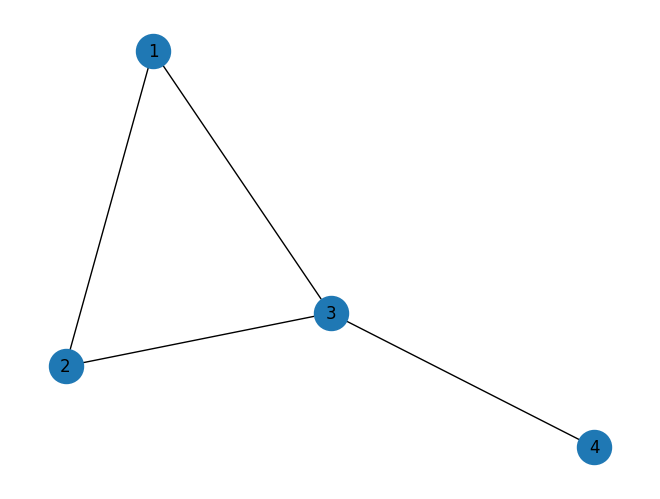

In [ ]:
n = 4
graph5 = rx.PyGraph()
graph5.add_nodes_from(np.arange(0, n+1, 1));graph5.remove_node(0)
graph5_edges = [(1, 2, 1.0), (1, 3, 1.0),  (2, 3, 1.0), (3, 4, 1.0)]
graph5.add_edges_from(graph5_edges)
graph5adj = to_adj_mat(graph5)
draw_graph(graph5, node_size=600, with_labels=True)

### creating subgraph

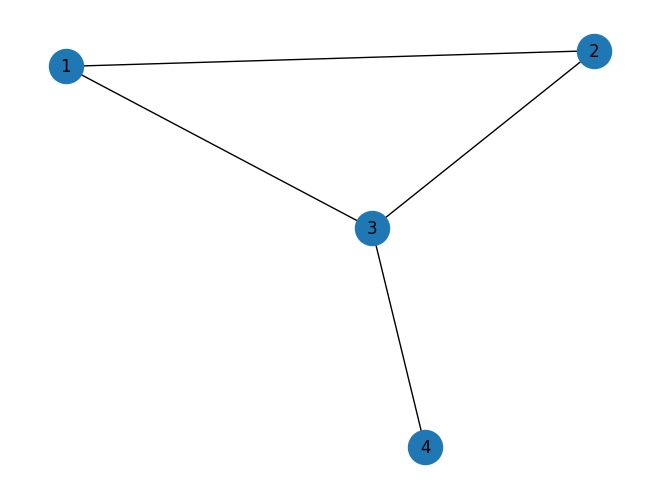

In [56]:
n = 4
subgraph5 = rx.PyGraph()
subgraph5.add_nodes_from(np.arange(0, n+1, 1));subgraph5.remove_node(0)
subgraph5_edges = [(1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0),(3, 4, 1.0)]
subgraph5.add_edges_from(subgraph5_edges)
subgraph5adj = to_adj_mat(subgraph5)
draw_graph(subgraph5, node_size=600, with_labels=True)

In [23]:
subgraph5adj

array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.]])

## Creating 10 Nodes graph

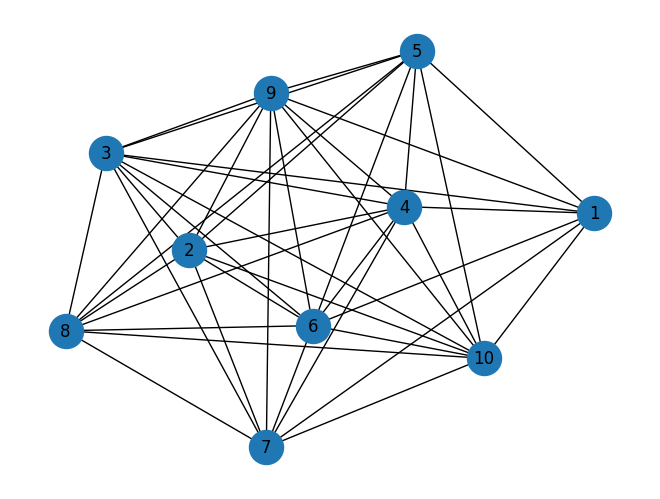

In [31]:
n = 10
graph10_edges = [(1,3,1.0), (1,4,1.0), (1,5,1.0), (1,6,1.0), (1,7,1.0), (1,9,1.0), (1,10,1.0), (2,3,1.0), (2,4,1.0), (2,5,1.0), (2,6,1.0), (2,7,1.0), (2,8,1.0), (2,9,1.0), (2,10,1.0), (3,4,1.0), (3,5,1.0), (3,6,1.0), (3,7,1.0), (3,8,1.0), (3,9,1.0), (3,10,1.0), (4,5,1.0), (4,6,1.0), (4,7,1.0), (4,8,1.0), (4,9,1.0), (4,10,1.0), (5,6,1.0), (5,8,1.0), (5,9,1.0), (5,10,1.0), (6,7,1.0), (6,8,1.0), (6,9,1.0), (6,10,1.0), (7,8,1.0), (7,9,1.0), (7,10,1.0), (8,9,1.0), (8,10,1.0), (9,10,1.0)]
graph10 = rx.PyGraph()
graph10.add_nodes_from(np.arange(0, n+1, 1));graph10.remove_node(0)
graph10.add_edges_from(graph10_edges)
graph10adj = to_adj_mat(graph10)
draw_graph(graph10, node_size=600, with_labels=True)

### creating subgraph

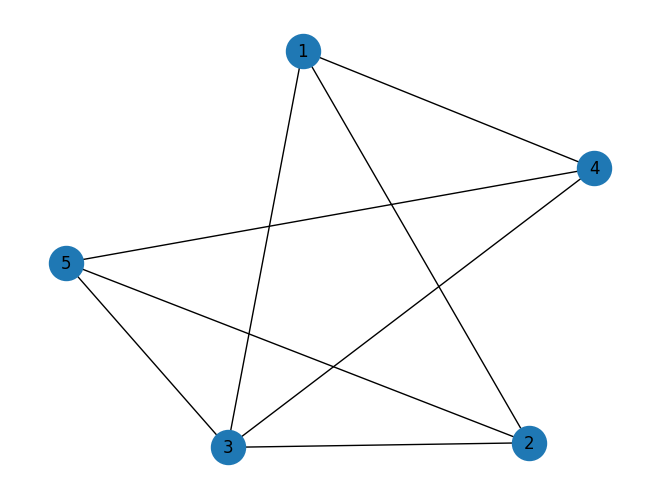

In [33]:
n = 5
subgraph10_edges = [(1,2,1.0), (1,3,1.0), (1,4,1.0),(2,3,1.0), (2,5,1.0),(3,4,1.0), (3,5,1.0), (4,5,1.0)]
subgraph10 = rx.PyGraph()
subgraph10.add_nodes_from(np.arange(0, n+1, 1));subgraph10.remove_node(0)
subgraph10.add_edges_from(subgraph10_edges)
subgraph10adj = to_adj_mat(subgraph10)
draw_graph(subgraph10, node_size=600, with_labels=True)

## Creating 15 Nodes graph

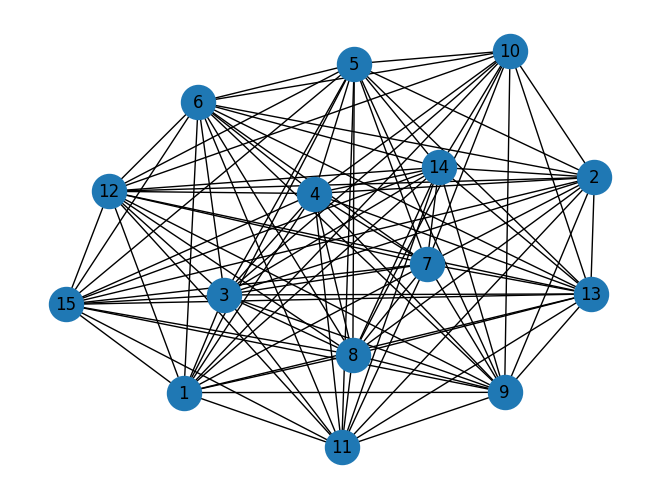

In [35]:
n = 15
graph15_edges = [(1,3,1.0), (1,4,1.0), (1,5,1.0), (1,6,1.0), (1,7,1.0), (1,8,1.0), (1,9,1.0), (1,10,1.0), (1,11,1.0), (1,12,1.0), (1,13,1.0), (1,14,1.0), (1,15,1.0), (2,3,1.0), (2,4,1.0), (2,5,1.0), (2,6,1.0), (2,7,1.0), (2,8,1.0), (2,9,1.0), (2,10,1.0), (2,11,1.0), (2,12,1.0), (2,13,1.0), (2,14,1.0), (2,15,1.0), (3,4,1.0), (3,5,1.0), (3,6,1.0), (3,7,1.0), (3,8,1.0), (3,9,1.0), (3,10,1.0), (3,11,1.0), (3,12,1.0), (3,13,1.0), (3,14,1.0), (3,15,1.0), (4,5,1.0), (4,6,1.0), (4,7,1.0), (4,8,1.0), (4,9,1.0), (4,10,1.0), (4,11,1.0), (4,12,1.0), (4,13,1.0), (4,14,1.0), (4,15,1.0), (5,6,1.0), (5,7,1.0), (5,8,1.0), (5,9,1.0), (5,10,1.0), (5,11,1.0), (5,12,1.0), (5,13,1.0), (5,14,1.0), (5,15,1.0), (6,7,1.0), (6,8,1.0), (6,9,1.0), (6,10,1.0), (6,11,1.0), (6,12,1.0), (6,13,1.0), (6,14,1.0), (6,15,1.0), (7,8,1.0), (7,9,1.0), (7,10,1.0), (7,11,1.0), (7,12,1.0), (7,13,1.0), (7,14,1.0), (7,15,1.0), (8,9,1.0), (8,10,1.0), (8,11,1.0), (8,12,1.0), (8,13,1.0), (8,14,1.0), (8,15,1.0), (9,10,1.0), (9,11,1.0), (9,12,1.0), (9,13,1.0), (9,14,1.0), (9,15,1.0), (10,12,1.0), (10,13,1.0), (10,14,1.0), (11,12,1.0), (11,13,1.0), (11,14,1.0), (11,15,1.0), (12,13,1.0), (12,14,1.0), (12,15,1.0), (13,14,1.0), (13,15,1.0), (14,15,1.0)]
graph15 = rx.PyGraph()
graph15.add_nodes_from(np.arange(0, n+1, 1));graph15.remove_node(0)
graph15.add_edges_from(graph15_edges)
graph15adj = to_adj_mat(graph15)
draw_graph(graph15, node_size=600, with_labels=True)

### creating subgraph

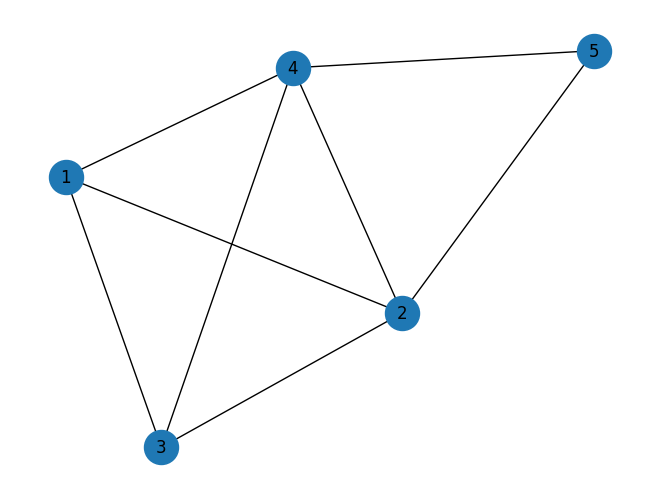

In [37]:
n = 5
subgraph15_edges = [(1,2,1.0), (1,3,1.0), (1,4,1.0),(2,3,1.0), (2,4,1.0),(2,5,1.0), (3,4,1.0),(4,5,1.0)]
subgraph15 = rx.PyGraph()
subgraph15.add_nodes_from(np.arange(0, n+1, 1));subgraph15.remove_node(0)
subgraph15.add_edges_from(subgraph15_edges)
subgraph15adj = to_adj_mat(subgraph15)
draw_graph(subgraph15, node_size=600, with_labels=True)

# QAOA for Subgraph Isomorphism

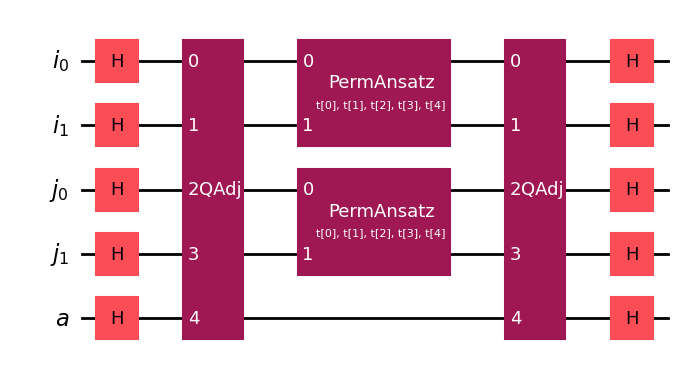

In [57]:
qc, params = ansatz(graph5adj,subgraph5adj)
qc.draw('mpl')

In [58]:
params

array([[ParameterVectorElement(t[0]), ParameterVectorElement(t[1]),
        ParameterVectorElement(t[2]), ParameterVectorElement(t[3]),
        ParameterVectorElement(t[4])]], dtype=object)

In [59]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="d4f5110e04c0beeb25dfe27667a7a28eb30630d05c9182f76644a3c1688bd36de9291b8759b5fd6fae9801ef36abf212a14822fee920912d7b1ea436ec4f0662", overwrite=True, set_as_default=True)
service1 = QiskitRuntimeService(channel='ibm_quantum')

In [60]:
backend5 = service1.least_busy(min_num_qubits=7,simulator=False, operational=True)
print(backend5)

<IBMBackend('ibm_brisbane')>


In [61]:
sim_backend5 = AerSimulator.from_backend(backend5)
sim_backend5.set_max_qubits(7)
#sim_backend5 = AerSimulator(method="automatic",noise_model=NoiseModel.from_backend(backend5))
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=sim_backend5)

sim_candidate_circuit5 = pm.run(qc)

In [62]:
estimator = Estimator(mode=sim_backend5)
#estimator.options.default_shots = 1000

In [71]:
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms import VQE
from tqdm import tqdm

In [64]:
seed = 10283764
rng = np.random.default_rng(seed=seed)

In [66]:
max_trials = 3
# qi = QuantumInstance(Aer.get_backend('statevector_simulator'),
#                      seed_transpiler=seed, seed_simulator=seed,
#                      shots=1024)
optim = SLSQP(maxiter=1000) # Init classical optimizer.

def trial():
    # Randomize initial parameters.
    initial_point = (rng.uniform(size=len(qc.parameters)) - 1/2) * np.pi
    vqe = VQE(estimator,qc,optim, initial_point=initial_point)
    obj = vqe.compute_minimum_eigenvalue(observable(qc.num_qubits))
    return obj.optimal_value, obj

In [72]:
results = [trial() for _ in tqdm(range(max_trials))]
results = sorted(results, key=lambda obj: obj[0])
result = results[0][1]

  0%|          | 0/3 [00:00<?, ?it/s]


AlgorithmError: 'The primitive job to evaluate the energy failed!'

## Preparing Cost Hamiltonian

In [3]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]-1], paulis[edge[1]-1] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

In [17]:
max_cut_paulis5 = build_max_cut_paulis(graph5)
cost_hamiltonian5 = SparsePauliOp.from_list(max_cut_paulis5)
print("Cost Function Hamiltonian of 5 Nodes graph:", cost_hamiltonian5)

Cost Function Hamiltonian of 5 Nodes graph: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [18]:
max_cut_paulis10 = build_max_cut_paulis(graph10)
cost_hamiltonian10 = SparsePauliOp.from_list(max_cut_paulis10)
print("Cost Function Hamiltonian of 10 Nodes graph:", cost_hamiltonian10)

Cost Function Hamiltonian of 10 Nodes graph: SparsePauliOp(['IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IIIIIZIIZI', 'IIIIZIIIZI', 'IIIZIIIIZI', 'IIZIIIIIZI', 'IZIIIIIIZI', 'ZIIIIIIIZI', 'IIIIIIZZII', 'IIIIIZIZII', 'IIIIZIIZII', 'IIIZIIIZII', 'IIZIIIIZII', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIIIIZZIII', 'IIIIZIZIII', 'IIIZIIZIII', 'IIZIIIZIII', 'IZIIIIZIII', 'ZIIIIIZIII', 'IIIIZZIIII', 'IIIZIZIIII', 'IIZIIZIIII', 'IZIIIZIIII', 'ZIIIIZIIII', 'IIIZZIIIII', 'IIZIZIIIII', 'IZIIZIIIII', 'ZIIIZIIIII', 'IIZZIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1

In [4]:
max_cut_paulis15 = build_max_cut_paulis(graph15)
cost_hamiltonian15 = SparsePauliOp.from_list(max_cut_paulis15)
print("Cost Function Hamiltonian of 15 Nodes graph:", cost_hamiltonian15)

Cost Function Hamiltonian of 15 Nodes graph: SparsePauliOp(['IIIIIIIIIIIIZIZ', 'IIIIIIIIIIIZIIZ', 'IIIIIIIIIIZIIIZ', 'IIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIZ', 'IIIIIIIZIIIIIIZ', 'IIIIIIZIIIIIIIZ', 'IIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIZ', 'IIIZIIIIIIIIIIZ', 'IIZIIIIIIIIIIIZ', 'IZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZZI', 'IIIIIIIIIIIZIZI', 'IIIIIIIIIIZIIZI', 'IIIIIIIIIZIIIZI', 'IIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIZI', 'IIIIIIZIIIIIIZI', 'IIIIIZIIIIIIIZI', 'IIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIZI', 'IIZIIIIIIIIIIZI', 'IZIIIIIIIIIIIZI', 'ZIIIIIIIIIIIIZI', 'IIIIIIIIIIIZZII', 'IIIIIIIIIIZIZII', 'IIIIIIIIIZIIZII', 'IIIIIIIIZIIIZII', 'IIIIIIIZIIIIZII', 'IIIIIIZIIIIIZII', 'IIIIIZIIIIIIZII', 'IIIIZIIIIIIIZII', 'IIIZIIIIIIIIZII', 'IIZIIIIIIIIIZII', 'IZIIIIIIIIIIZII', 'ZIIIIIIIIIIIZII', 'IIIIIIIIIIZZIII', 'IIIIIIIIIZIZIII', 'IIIIIIIIZIIZIII', 'IIIIIIIZIIIZIII', 'IIIIIIZIIIIZIII', 'IIIIIZIIIIIZIII', 'IIIIZIIIIIIZIII', 'IIIZIIIIIIIZIII', 'IIZIIIIIIIIZIII', 'IZIIIIIIIIIZIII', 'ZIIIIIIIIIIZIII', 'IIIIIIII

## Preparing Parametrized circuit(Ansatz)
Note: the Initial state is equisuperposition state

In [5]:
iterations = 2

In [ ]:
circuit5 = QAOAAnsatz(cost_operator=cost_hamiltonian5, reps=iterations)
circuit5.measure_all()

In [ ]:
circuit10 = QAOAAnsatz(cost_operator=cost_hamiltonian10, reps=iterations)
circuit10.measure_all()

In [7]:
circuit15 = QAOAAnsatz(cost_operator=cost_hamiltonian15, reps=iterations)
circuit15.measure_all()

## Transpiling circuits for Real and Fake Backends

In [8]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="d4f5110e04c0beeb25dfe27667a7a28eb30630d05c9182f76644a3c1688bd36de9291b8759b5fd6fae9801ef36abf212a14822fee920912d7b1ea436ec4f0662", overwrite=True, set_as_default=True)
service1 = QiskitRuntimeService(channel='ibm_quantum')

### Real backends

In [72]:
backend5 = service1.least_busy(min_num_qubits=5,simulator=False, operational=True)
print(backend5)
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend5)

candidate_circuit5 = pm.run(circuit5)

<IBMBackend('ibm_brisbane')>


In [125]:
#backend10 = service1.least_busy(min_num_qubits=10,simulator=False, operational=True)
backend10 = service1.backend("ibm_brisbane")
print(backend10)
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend10)

candidate_circuit10 = pm.run(circuit10)

<IBMBackend('ibm_brisbane')>


In [15]:
#backend15 = service1.backend("ibm_brisbane")
backend15 = service1.least_busy(min_num_qubits=15,simulator=False, operational=True)
print(backend15)
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend15)

candidate_circuit15 = pm.run(circuit15)

<IBMBackend('ibm_kyiv')>


### Fake backends (Aer Simulator with noise model of real machine)

In [103]:
sim_backend5 = AerSimulator.from_backend(backend5)
sim_backend5.set_max_qubits(5)
#sim_backend5 = AerSimulator(method="automatic",noise_model=NoiseModel.from_backend(backend5))
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=sim_backend5)

sim_candidate_circuit5 = pm.run(circuit5)

In [112]:
sim_backend10 = AerSimulator.from_backend(backend10)
sim_backend10.set_max_qubits(10)
#sim_backend10 = AerSimulator(method="automatic",noise_model=NoiseModel.from_backend(backend10))
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=sim_backend10)

sim_candidate_circuit10 = pm.run(circuit10)

In [138]:
sim_backend15 = AerSimulator.from_backend(backend15)
sim_backend15.set_max_qubits(15)
#sim_backend15 = AerSimulator(method="automatic",noise_model=NoiseModel.from_backend(backend15))
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=sim_backend15)

sim_candidate_circuit15 = pm.run(circuit15)

In [139]:
sim_backend15.num_qubits

127

## QAOA iterations
Note: Estimator primitive is used to estimate the expected Cost function in optimization loop and Sampler primitive is used to get minimum cost eigenvector probability distribution

### Defining initial parameters

In [12]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]*iterations

### Optimization Loop

In [13]:
def cost_func_estimator(params, ansatz, hamiltonian,sessionl,estimatorl,backend, objective_func_vals):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    if (len(sessionl)==0 or sessionl[-1].details()['state']=='closed'): #need to start new session and instantiate estimator
        session = Session(backend=backend)
        estimator = Estimator(mode=session)
        estimator.options.default_shots = 1000
        estimator.options.dynamical_decoupling.enable = True
        estimator.options.dynamical_decoupling.sequence_type = "XY4"
        estimator.options.twirling.enable_gates = True
        estimator.options.twirling.num_randomizations = "auto"
        if (len(sessionl)==0) : 
            sessionl.append( session )
            estimatorl.append(estimator)
        else : 
            sessionl[-1] = session
            estimatorl[-1] = estimator

    job = estimatorl[-1].run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

#### Running on real machines

In [ ]:
%%time
objective_func_vals5 = [] # Global variable
session5 = []
estimator5 = []
#with Session(backend=backend5,max_time=86400) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`

result1 = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit5, cost_hamiltonian5, session5, estimator5, backend5, objective_func_vals5),
    method="COBYLA",
    tol=1e-2,
)
session5[-1].close()
print(result1)

> graph5 took 6.067 min on QPU (4s for sampling on QPU) and 2.22 min on CPU, thus 8.287 min Total processing time

In [126]:
%%time
objective_func_vals10 = [] # Global variable
session10 = []
estimator10 = []
#with Session(backend=backend5,max_time=86400) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`

result2 = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit10, cost_hamiltonian10, session10, estimator10, backend10, objective_func_vals10),
    method="COBYLA",
    tol=1e-2,
)
session10[-1].close()
print(result2)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.22796442760776017
       x: [ 4.142e+00  2.653e+00  3.385e+00  1.505e+00]
    nfev: 28
   maxcv: 0.0
CPU times: user 2min 10s, sys: 2.9 s, total: 2min 13s
Wall time: 46min 8s


> graph10 took 5.05 min on QPU (6s for sampling on QPU) and 2.22 min on CPU, thus 7.27 min Total processing time

In [16]:
%%time
objective_func_vals15 = [] # Global variable
session15 = []
estimator15 = []
#with Session(backend=backend5,max_time=86400) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`

result3 = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit15, cost_hamiltonian15, session15, estimator15, backend15, objective_func_vals15),
    method="COBYLA",
    tol=1e-2,
)
session15[-1].close()
print(result3)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.07607107243454184
       x: [ 3.134e+00  1.632e+00  3.146e+00  1.464e+00]
    nfev: 25
   maxcv: 0.0
CPU times: user 2min 21s, sys: 3.98 s, total: 2min 25s
Wall time: 1h 12min 35s


> graph15 took 4.97 min on QPU (6s for sampling on QPU) and 2.42 min on CPU, thus 7.39 min Total processing time

#### Running on simulator

In [114]:
def cost_func_estimator_sim(params, ansatz, hamiltonian,estimator, objective_func_vals):
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)
    return cost

In [107]:
%%time
sim_objective_func_vals5 = [] # Global variable
estimator = Estimator(mode=sim_backend5)
estimator.options.default_shots = 1000
sim_result1 = minimize(
    cost_func_estimator_sim,
    init_params,
    args=(sim_candidate_circuit5, cost_hamiltonian5, estimator, sim_objective_func_vals5),
    method="COBYLA",
    tol=1e-2,
)
print(sim_result1)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.151848151848152
       x: [ 3.352e+00  2.800e+00  2.668e+00  8.685e-01]
    nfev: 39
   maxcv: 0.0
CPU times: user 1min 36s, sys: 59.5 ms, total: 1min 36s
Wall time: 1min 21s


In [119]:
print(len(sim_objective_func_vals5))

39


In [135]:
%%time
sim_objective_func_vals10 = [] # Global variable

estimator = Estimator(mode=sim_backend10)
estimator.options.default_shots = 1000

sim_result2 = minimize(
    cost_func_estimator_sim,
    init_params,
    args=(sim_candidate_circuit10, cost_hamiltonian10, estimator, sim_objective_func_vals10),
    method="COBYLA",
    tol=1e-2,
)
print(sim_result2)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.11988011988011982
       x: [ 4.134e+00  2.565e+00  4.129e+00  1.560e+00]
    nfev: 25
   maxcv: 0.0
CPU times: user 19min 13s, sys: 2.47 s, total: 19min 15s
Wall time: 3min 38s


In [117]:
print(len(sim_objective_func_vals10))

25


In [140]:
%%time
sim_objective_func_vals15 = [] # Global variable

estimator = Estimator(mode=sim_backend15)
estimator.options.default_shots = 1000

sim_result3 = minimize(
    cost_func_estimator_sim,
    init_params,
    args=(sim_candidate_circuit15, cost_hamiltonian15, estimator, sim_objective_func_vals15),
    method="COBYLA",
    tol=1e-2,
)
print(sim_result3)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.17382617382617402
       x: [ 4.146e+00  2.570e+00  3.150e+00  1.575e+00]
    nfev: 24
   maxcv: 0.0
CPU times: user 3h 47s, sys: 14.3 s, total: 3h 1min 2s
Wall time: 25min 13s


In [141]:
print(len(sim_objective_func_vals15))

24


### Plotting Energy vs Iterations

#### Real machine outputs

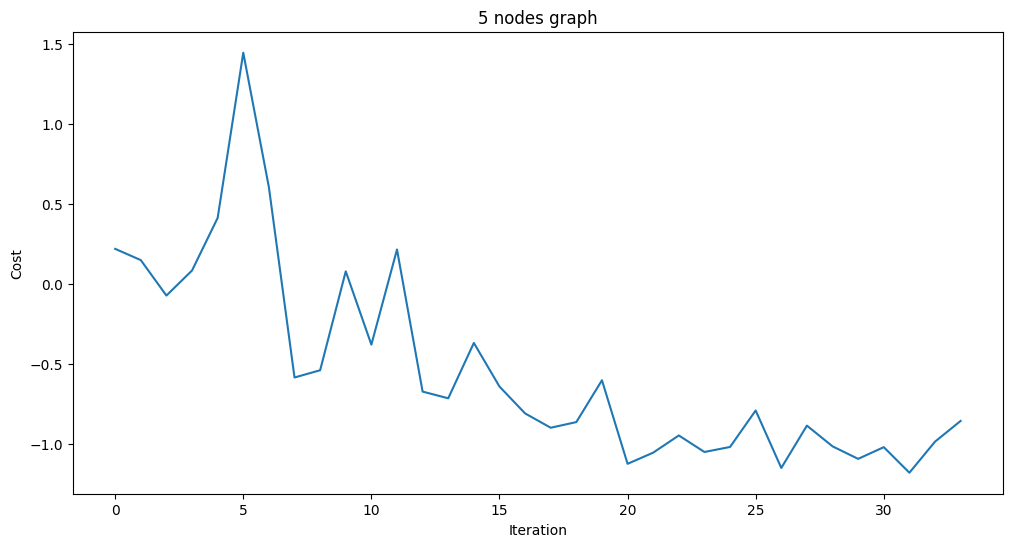

In [77]:
plt.figure(figsize=(12, 6))
plt.title("5 nodes graph")
plt.plot(objective_func_vals5)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

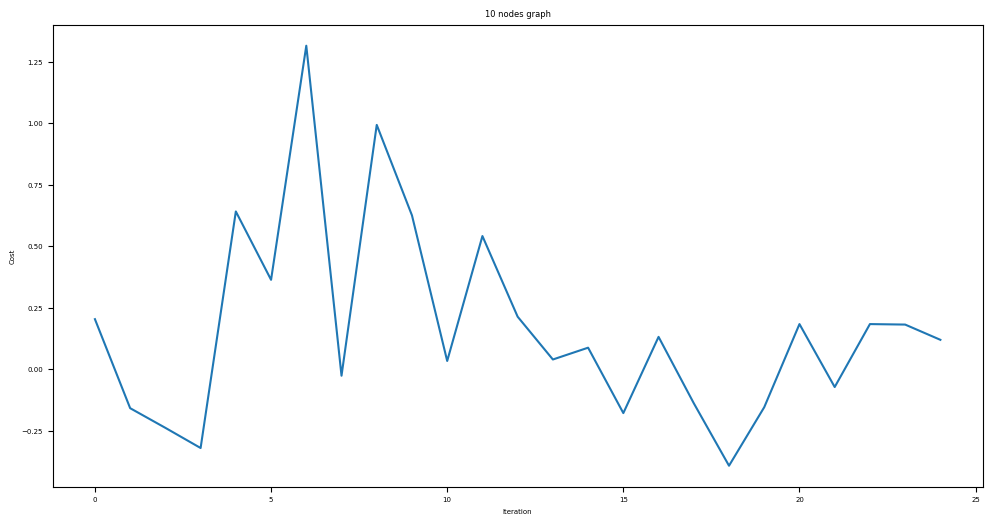

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("10 nodes graph")
plt.plot(objective_func_vals10)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

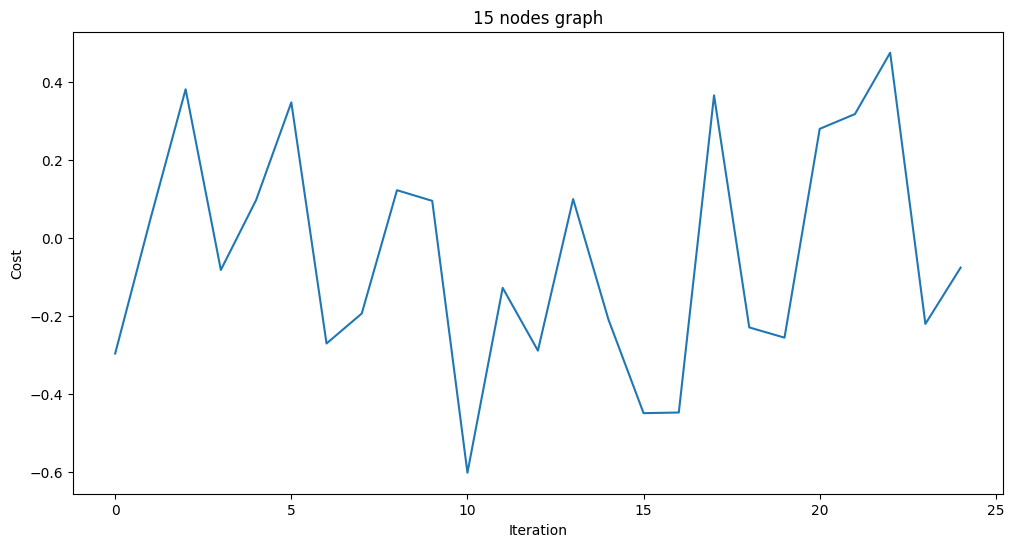

In [17]:
plt.figure(figsize=(12, 6))
plt.title("15 nodes graph")
plt.plot(objective_func_vals15)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

#### Simulator outputs

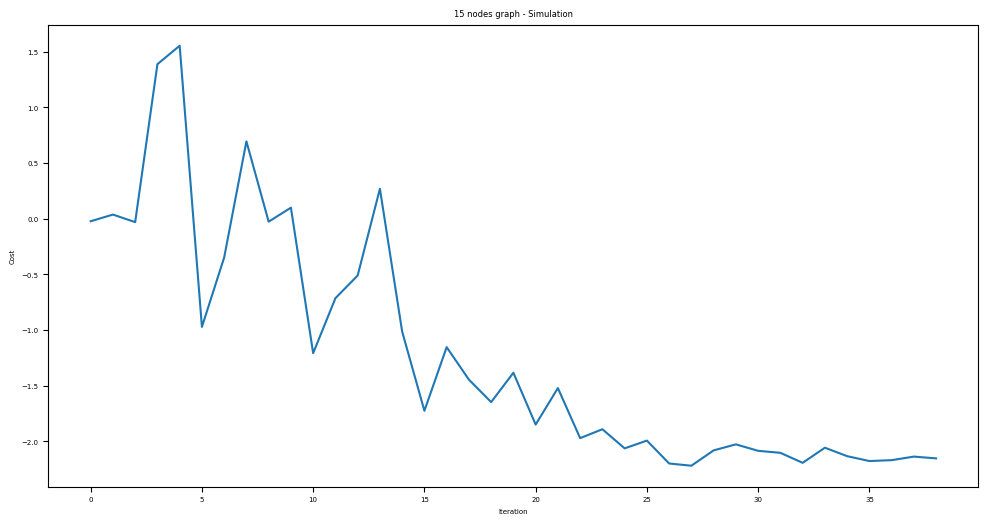

In [144]:
plt.figure(figsize=(12, 6))
plt.title("15 nodes graph - Simulation")
plt.plot(sim_objective_func_vals5)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

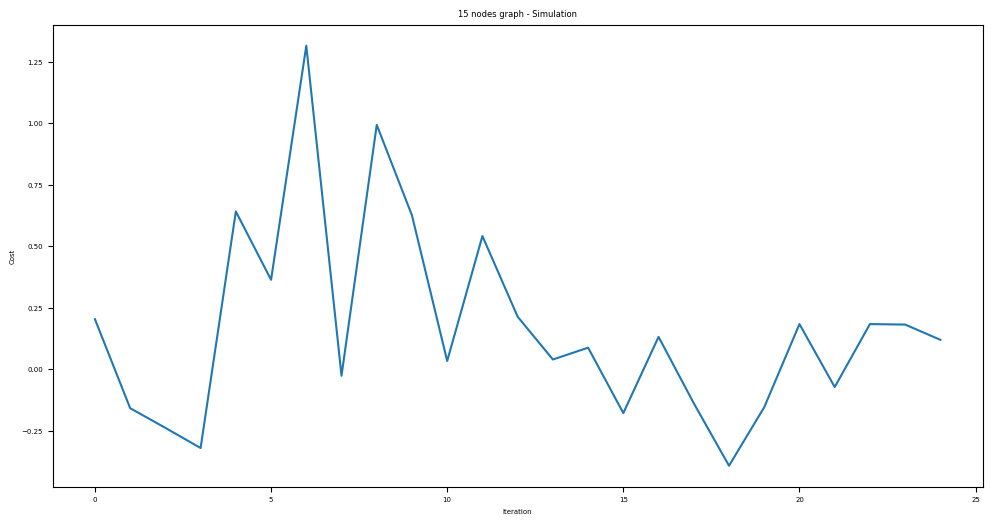

In [145]:
plt.figure(figsize=(12, 6))
plt.title("15 nodes graph - Simulation")
plt.plot(sim_objective_func_vals10)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

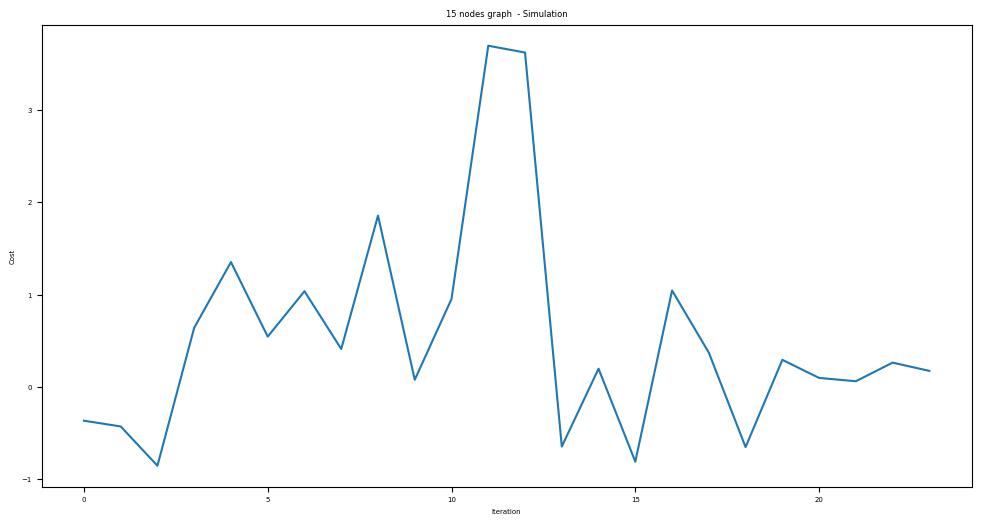

In [146]:
plt.figure(figsize=(12, 6))
plt.title("15 nodes graph  - Simulation")
plt.plot(sim_objective_func_vals15)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

### Sampling Max-cut solutions from optimized circuit

#### Real Machine run

In [ ]:
optimized_circuit5 = candidate_circuit5.assign_parameters(result1.x)
session1 = Session(backend=backend5)
sampler1 = Sampler(mode=session1)
sampler1.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler1.options.dynamical_decoupling.enable = True
sampler1.options.dynamical_decoupling.sequence_type = "XY4"
sampler1.options.twirling.enable_gates = True
sampler1.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit5, )
job5 = sampler1.run([pub], shots=int(1e4))
session1.close()
counts_int = job5.result()[0].data.meas.get_int_counts()
counts_bin = job5.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int5 = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin5 = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int5)

{3: 0.0281, 11: 0.0498, 19: 0.0455, 7: 0.0196, 2: 0.026, 31: 0.0122, 20: 0.0449, 18: 0.0338, 17: 0.0462, 0: 0.0132, 22: 0.0447, 24: 0.0235, 25: 0.0233, 4: 0.0179, 16: 0.0229, 28: 0.0223, 26: 0.0516, 5: 0.0553, 12: 0.0418, 23: 0.0213, 10: 0.041, 13: 0.0382, 27: 0.0212, 21: 0.0397, 9: 0.0581, 14: 0.0311, 1: 0.0189, 8: 0.0248, 30: 0.0171, 15: 0.0167, 29: 0.0319, 6: 0.0174}


/tmp/ipykernel_28297/1826480466.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


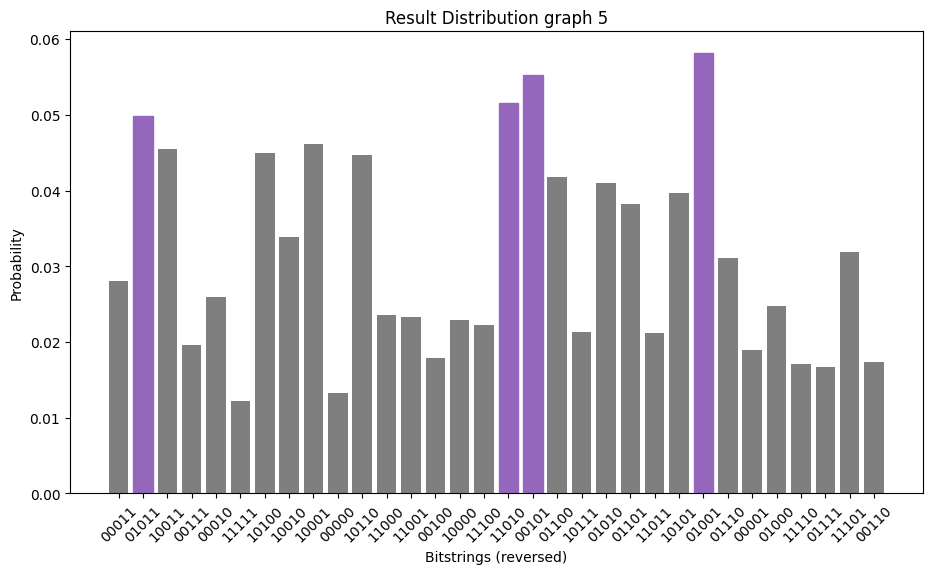

In [87]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin5
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution graph 5")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

In [128]:
optimized_circuit10 = candidate_circuit10.assign_parameters(result2.x)
session2 = Session(backend=backend10)
sampler2 = Sampler(mode=session2)
sampler2.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler2.options.dynamical_decoupling.enable = True
sampler2.options.dynamical_decoupling.sequence_type = "XY4"
sampler2.options.twirling.enable_gates = True
sampler2.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit10, )
job10 = sampler2.run([pub], shots=int(1e4))
session2.close()
counts_int = job10.result()[0].data.meas.get_int_counts()
counts_bin = job10.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int10 = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin10 = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int10)

{791: 0.0018, 490: 0.0013, 723: 0.0011, 918: 0.0011, 364: 0.0007, 389: 0.0012, 615: 0.0017, 39: 0.0018, 199: 0.0015, 329: 0.0013, 138: 0.001, 501: 0.0015, 148: 0.0006, 888: 0.0008, 270: 0.0012, 192: 0.001, 201: 0.0006, 511: 0.0011, 334: 0.0009, 997: 0.0012, 146: 0.0014, 461: 0.0006, 735: 0.0011, 234: 0.0011, 969: 0.0009, 486: 0.0009, 1005: 0.0009, 727: 0.0012, 27: 0.0013, 88: 0.0015, 419: 0.0011, 762: 0.001, 351: 0.0014, 853: 0.0012, 489: 0.0009, 813: 0.0006, 217: 0.0013, 712: 0.0003, 206: 0.0015, 300: 0.0007, 356: 0.0011, 945: 0.001, 127: 0.0013, 698: 0.0016, 512: 0.0004, 46: 0.0003, 821: 0.0005, 1017: 0.0009, 131: 0.0007, 327: 0.0017, 614: 0.0008, 823: 0.0015, 822: 0.0006, 412: 0.0011, 133: 0.0009, 711: 0.0013, 410: 0.0008, 187: 0.0011, 167: 0.0013, 202: 0.0009, 87: 0.0016, 678: 0.0013, 450: 0.0013, 244: 0.001, 610: 0.0013, 239: 0.0013, 215: 0.0012, 172: 0.0012, 630: 0.001, 322: 0.001, 939: 0.0016, 627: 0.0008, 498: 0.0005, 154: 0.0011, 153: 0.0013, 745: 0.0009, 666: 0.0008, 169: 0.0

TypeError: only length-1 arrays can be converted to Python scalars

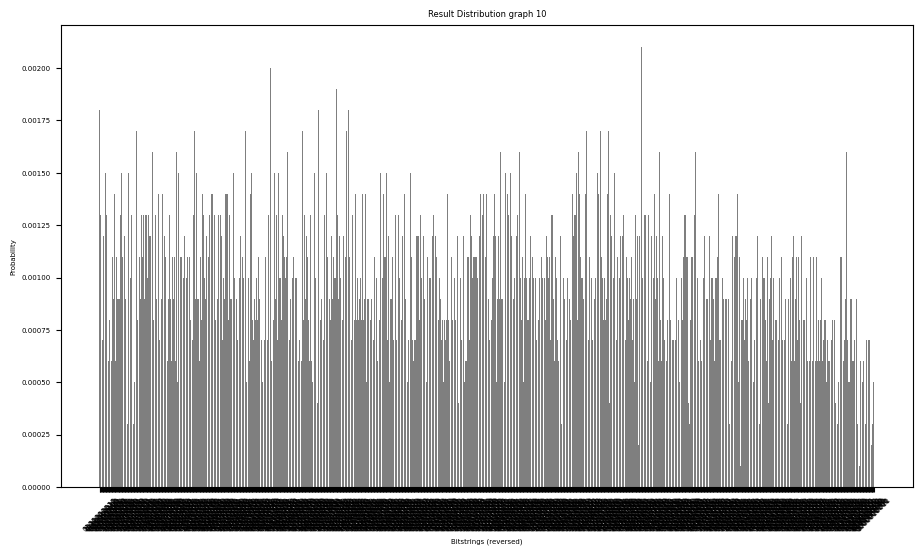

In [ ]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin10
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution graph 10")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

In [18]:
optimized_circuit15 = candidate_circuit15.assign_parameters(result3.x)
session3 = Session(backend=backend15)
sampler3 = Sampler(mode=session3)
sampler3.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler3.options.dynamical_decoupling.enable = True
sampler3.options.dynamical_decoupling.sequence_type = "XY4"
sampler3.options.twirling.enable_gates = True
sampler3.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit15, )
job15 = sampler3.run([pub], shots=int(1e4))
session3.close()
counts_int = job15.result()[0].data.meas.get_int_counts()
counts_bin = job15.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int15 = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin15 = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int15)

{32523: 0.0003, 4460: 0.0001, 11128: 0.0001, 15493: 0.0001, 3134: 0.0001, 21502: 0.0001, 25399: 0.0001, 9382: 0.0001, 7809: 0.0001, 14585: 0.0002, 1955: 0.0001, 21933: 0.0001, 14293: 0.0001, 25809: 0.0002, 20739: 0.0002, 11859: 0.0002, 7799: 0.0002, 29684: 0.0001, 26458: 0.0002, 32344: 0.0001, 3443: 0.0001, 25921: 0.0001, 1736: 0.0001, 26788: 0.0002, 5674: 0.0002, 27205: 0.0001, 2033: 0.0001, 26684: 0.0001, 3748: 0.0002, 24244: 0.0001, 9449: 0.0003, 22620: 0.0001, 5448: 0.0001, 3129: 0.0001, 1924: 0.0001, 1928: 0.0002, 21128: 0.0001, 28595: 0.0002, 11775: 0.0002, 19034: 0.0003, 20301: 0.0001, 32171: 0.0002, 20463: 0.0003, 5023: 0.0001, 18261: 0.0001, 31931: 0.0001, 8999: 0.0001, 31637: 0.0001, 30878: 0.0001, 4800: 0.0001, 22053: 0.0001, 25069: 0.0001, 17610: 0.0001, 15232: 0.0002, 11277: 0.0001, 19163: 0.0002, 16531: 0.0001, 15094: 0.0001, 11982: 0.0001, 27809: 0.0001, 1007: 0.0002, 2103: 0.0001, 5606: 0.0001, 3414: 0.0001, 26962: 0.0001, 3581: 0.0001, 9513: 0.0001, 10134: 0.0001, 2493

TypeError: only length-1 arrays can be converted to Python scalars

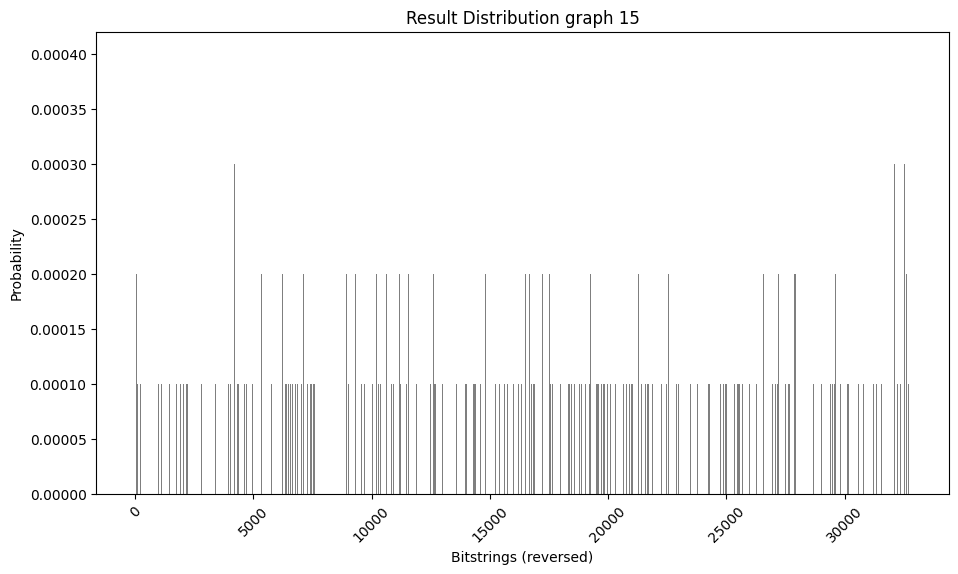

In [19]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_int15
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution graph 15")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

#### Simulator run

In [147]:
sim_optimized_circuit5 = sim_candidate_circuit5.assign_parameters(sim_result1.x)
sim_sampler1 = Sampler(mode=sim_backend5)
sim_sampler1.options.default_shots = 10000

pub= (sim_optimized_circuit5, )
sim_job5 = sim_sampler1.run([pub], shots=int(1e4))
counts_int = sim_job5.result()[0].data.meas.get_int_counts()
counts_bin = sim_job5.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
sim_final_distribution_int5 = {key: val/shots for key, val in counts_int.items()}
sim_final_distribution_bin5 = {key: val/shots for key, val in counts_bin.items()}
print(sim_final_distribution_int5)

{9: 0.1146, 31: 0.0075, 11: 0.1161, 0: 0.0071, 5: 0.0395, 17: 0.0152, 22: 0.121, 21: 0.051, 10: 0.0485, 14: 0.0145, 8: 0.0129, 12: 0.0175, 20: 0.1233, 13: 0.0437, 1: 0.0114, 19: 0.0133, 18: 0.0426, 27: 0.0169, 26: 0.0387, 23: 0.0129, 29: 0.0138, 15: 0.0081, 25: 0.0096, 16: 0.0098, 30: 0.0127, 24: 0.012, 2: 0.0149, 3: 0.0082, 6: 0.0088, 7: 0.013, 4: 0.0161, 28: 0.0048}


/tmp/ipykernel_28297/10558154.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


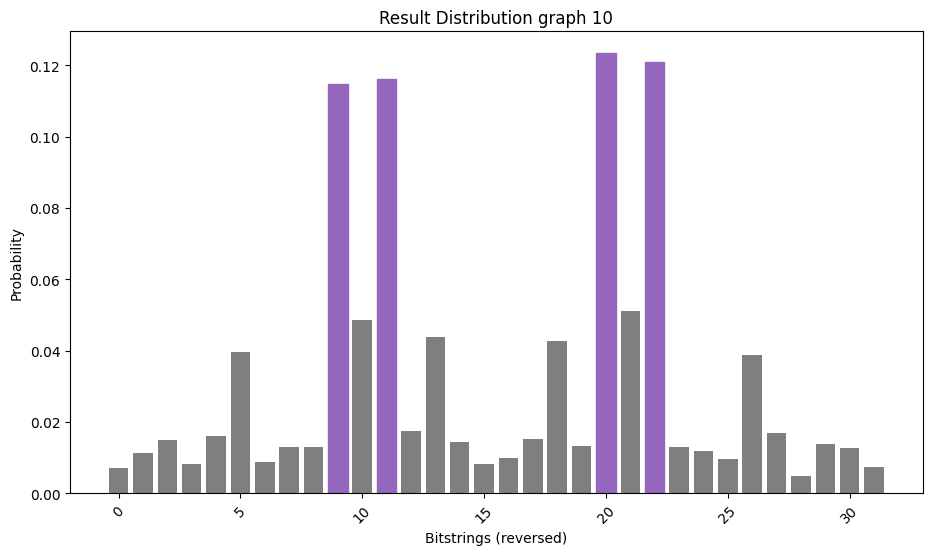

In [ ]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = sim_final_distribution_int5
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution graph 5")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

In [148]:
sim_optimized_circuit10 = sim_candidate_circuit5.assign_parameters(sim_result2.x)
sim_sampler2 = Sampler(mode=sim_backend10)
sim_sampler2.options.default_shots = 10000

pub= (sim_optimized_circuit10, )
sim_job10 = sim_sampler2.run([pub], shots=int(1e4))
counts_int = sim_job10.result()[0].data.meas.get_int_counts()
counts_bin = sim_job10.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
sim_final_distribution_int10 = {key: val/shots for key, val in counts_int.items()}
sim_final_distribution_bin10 = {key: val/shots for key, val in counts_bin.items()}
print(sim_final_distribution_int10)

{3: 0.0174, 30: 0.0177, 12: 0.0568, 17: 0.0587, 7: 0.0257, 6: 0.0125, 24: 0.0235, 18: 0.0195, 5: 0.0117, 19: 0.0632, 16: 0.0443, 20: 0.0343, 11: 0.0365, 9: 0.033, 8: 0.039, 31: 0.0656, 10: 0.0183, 14: 0.057, 13: 0.0224, 15: 0.0457, 29: 0.028, 27: 0.0145, 23: 0.0375, 4: 0.0162, 22: 0.0331, 0: 0.0619, 28: 0.0181, 1: 0.0172, 25: 0.0136, 21: 0.0197, 2: 0.0262, 26: 0.0112}


/tmp/ipykernel_28297/2840388008.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


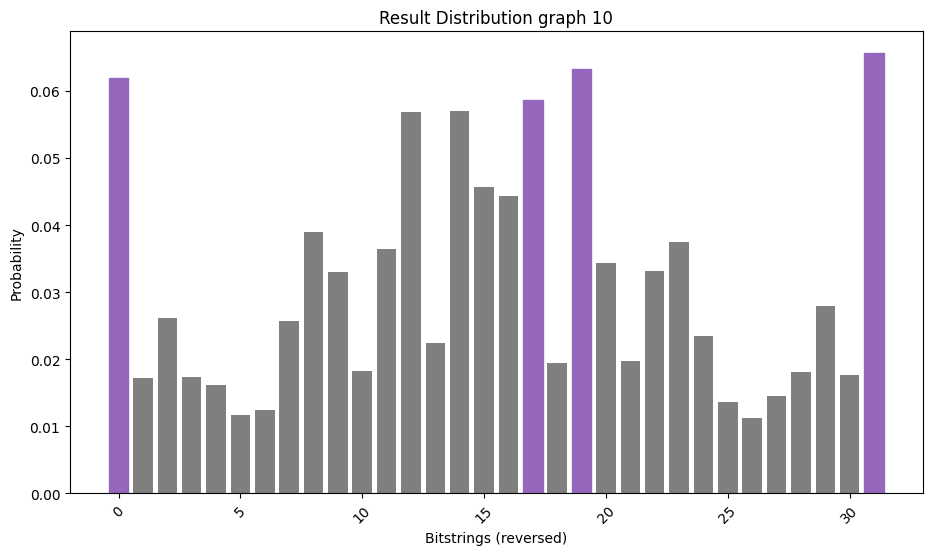

In [151]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = sim_final_distribution_int10
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution graph 10")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

In [149]:
sim_optimized_circuit15 = sim_candidate_circuit15.assign_parameters(sim_result3.x)
sim_sampler3 = Sampler(mode=sim_backend15)
sim_sampler3.options.default_shots = 10000

pub= (sim_optimized_circuit15, )
sim_job15 = sim_sampler3.run([pub], shots=int(1e4))
counts_int = sim_job15.result()[0].data.meas.get_int_counts()
counts_bin = sim_job15.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
sim_final_distribution_int15 = {key: val/shots for key, val in counts_int.items()}
sim_final_distribution_bin15 = {key: val/shots for key, val in counts_bin.items()}
print(sim_final_distribution_int15)

{26370: 0.0001, 17193: 0.0001, 19342: 0.0001, 11591: 0.0001, 16187: 0.0001, 22512: 0.0001, 30928: 0.0002, 15284: 0.0003, 10637: 0.0001, 6868: 0.0002, 19402: 0.0001, 5779: 0.0003, 19135: 0.0001, 22733: 0.0001, 21115: 0.0001, 26237: 0.0001, 28339: 0.0001, 13578: 0.0002, 28962: 0.0001, 31674: 0.0002, 2025: 0.0001, 27259: 0.0001, 12783: 0.0001, 22393: 0.0001, 12071: 0.0001, 27932: 0.0001, 21886: 0.0002, 26239: 0.0002, 6744: 0.0002, 26238: 0.0001, 8559: 0.0001, 13802: 0.0001, 3600: 0.0001, 2820: 0.0001, 1980: 0.0001, 7476: 0.0002, 22169: 0.0001, 12248: 0.0003, 15412: 0.0001, 9644: 0.0002, 31534: 0.0002, 22681: 0.0002, 27639: 0.0001, 3166: 0.0002, 7073: 0.0001, 8093: 0.0002, 14398: 0.0001, 7267: 0.0002, 25927: 0.0001, 12938: 0.0001, 6501: 0.0001, 31838: 0.0001, 27966: 0.0001, 8005: 0.0001, 3627: 0.0001, 6035: 0.0001, 29288: 0.0001, 14131: 0.0002, 26632: 0.0001, 29935: 0.0001, 3839: 0.0002, 24610: 0.0001, 26158: 0.0001, 31215: 0.0001, 17684: 0.0001, 16416: 0.0001, 21999: 0.0001, 28055: 0.0002

/tmp/ipykernel_28297/3086748664.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


TypeError: only length-1 arrays can be converted to Python scalars

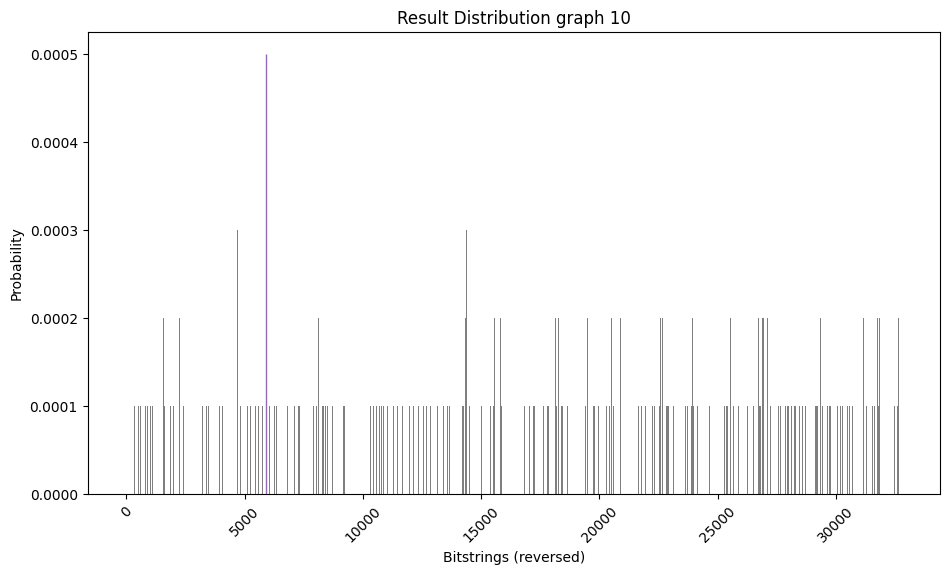

In [ ]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = sim_final_distribution_int15
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution graph 15")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

### Returning result in classical format

#### From real machines

In [20]:
def to_bitstring(integer, num_bits):    # auxiliary functions to sample most likely bitstring
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

In [ ]:
keys = list(final_distribution_int5.keys())
values = list(final_distribution_int5.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring5 = to_bitstring(most_likely, len(graph5))
most_likely_bitstring5.reverse()

print("Result bitstring:", most_likely_bitstring5)

Result bitstring: [1, 0, 0, 1, 0]


In [132]:
keys = list(final_distribution_int10.keys())
values = list(final_distribution_int10.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring10 = to_bitstring(most_likely, len(graph10))
most_likely_bitstring10.reverse()

print("Result bitstring:", most_likely_bitstring10)

Result bitstring: [1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


In [21]:
keys = list(final_distribution_int15.keys())
values = list(final_distribution_int15.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring15 = to_bitstring(most_likely, len(graph15))
most_likely_bitstring15.reverse()

print("Result bitstring:", most_likely_bitstring15)

Result bitstring: [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]


#### From simulators

In [153]:
keys = list(sim_final_distribution_int5.keys())
values = list(sim_final_distribution_int5.values())
sim_most_likely = keys[np.argmax(np.abs(values))]
sim_most_likely_bitstring5 = to_bitstring(sim_most_likely, len(graph5))
sim_most_likely_bitstring5.reverse()

print("Result bitstring:", sim_most_likely_bitstring5)

Result bitstring: [0, 0, 1, 0, 1]


In [154]:
keys = list(sim_final_distribution_int10.keys())
values = list(sim_final_distribution_int10.values())
sim_most_likely = keys[np.argmax(np.abs(values))]
sim_most_likely_bitstring10 = to_bitstring(sim_most_likely, len(graph10))
sim_most_likely_bitstring10.reverse()

print("Result bitstring:", sim_most_likely_bitstring10)

Result bitstring: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [155]:
keys = list(sim_final_distribution_int15.keys())
values = list(sim_final_distribution_int15.values())
sim_most_likely = keys[np.argmax(np.abs(values))]
sim_most_likely_bitstring15 = to_bitstring(sim_most_likely, len(graph15))
sim_most_likely_bitstring15.reverse()

print("Result bitstring:", sim_most_likely_bitstring15)

Result bitstring: [1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]


### Visualizing Max-cut in graph

#### From Real machine outputs

In [22]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)

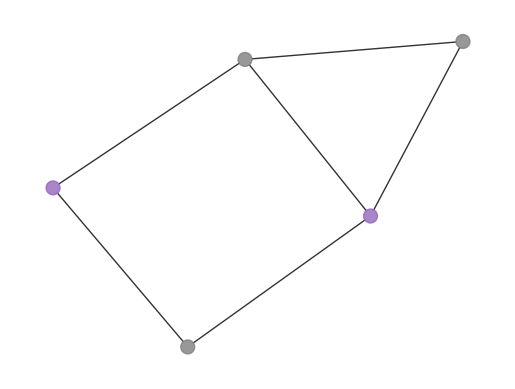

In [ ]:
# visualizing cut
plot_result(graph5, most_likely_bitstring5)

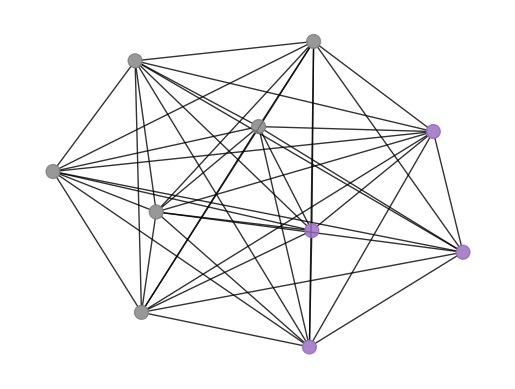

In [133]:
# visualizing cut
plot_result(graph10, most_likely_bitstring10)

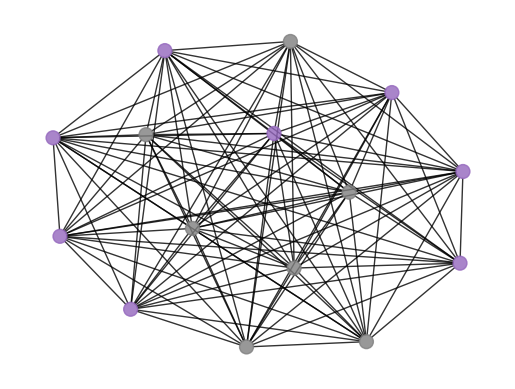

In [23]:
# visualizing cut
plot_result(graph15, most_likely_bitstring15)

#### From simulators output

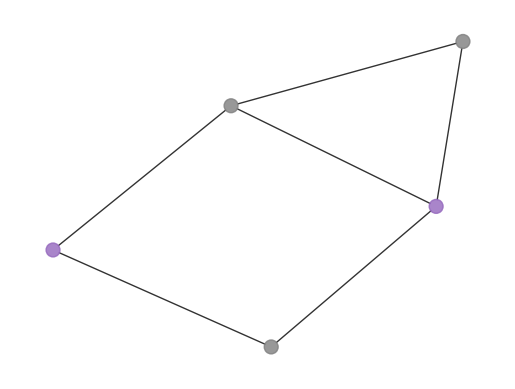

In [156]:
# visualizing cut
plot_result(graph5, sim_most_likely_bitstring5)

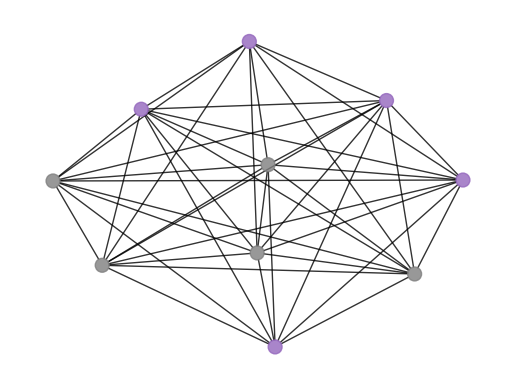

In [157]:
# visualizing cut
plot_result(graph10, sim_most_likely_bitstring10)

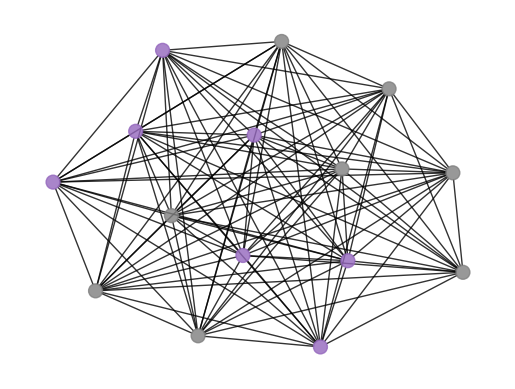

In [158]:
# visualizing cut
plot_result(graph15, sim_most_likely_bitstring15)

## Calculating value of Cut

In [24]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u-1] * (1 - x[v-1]) + x[v-1] * (1 - x[u-1]) for u, v in list(graph.edge_list()))

#### For Real Machines output

In [ ]:
cut_value5= evaluate_sample(most_likely_bitstring5, graph5)
print('The value of the cut of graph of 5 nodes is:', cut_value5)

The value of the cut of graph of 5 nodes is: 5


In [134]:
cut_value10= evaluate_sample(most_likely_bitstring10, graph10)
print('The value of the cut of the graph with 10 nodes is:', cut_value10)

The value of the cut of the graph with 10 nodes is: 24


In [25]:
cut_value15= evaluate_sample(most_likely_bitstring15, graph15)
print('The value of the cut of the graph with 15 nodes is:', cut_value15)

The value of the cut of the graph with 15 nodes is: 55


#### From Simulator output

In [159]:
sim_cut_value5= evaluate_sample(sim_most_likely_bitstring5, graph5)
print('The value of the cut of the graph with 5 nodes is:', sim_cut_value5)

The value of the cut of the graph with 5 nodes is: 5


In [160]:
sim_cut_value10= evaluate_sample(sim_most_likely_bitstring10, graph10)
print('The value of the cut of the graph with 10 nodes is:', sim_cut_value10)

The value of the cut of the graph with 10 nodes is: 25


In [161]:
sim_cut_value15= evaluate_sample(sim_most_likely_bitstring15, graph15)
print('The value of the cut of the graph with 15 nodes is:', sim_cut_value15)

The value of the cut of the graph with 15 nodes is: 55


## Quality of answer

#### Real machine answers

In [ ]:
Q = ( ( ((cut_value5-5)/5)**2 + ((cut_value10-25)/25)**2 + ((cut_value15-56)/56)**2 )/3 )**0.5
success_rate = (1-Q)*100
print("success rate:", success_rate,"%")

success rate: 97.47091745816762 %


#### Simulator answers

In [177]:
sim_Q = ( ( ((sim_cut_value5-5)/5)**2 + ((sim_cut_value10-25)/25)**2 + ((sim_cut_value15-56)/56)**2 ) /3 )**0.5
sim_success_rate = (1-sim_Q)*100
print("success rate:", sim_success_rate,"%")

success rate: 98.9690173764471 %


# Summarising results
| Algorithm | Time(5 nodes) | Time(10 nodes) | Time(15 nodes) | Success Rate |
| :-------: | :------------: | :------------: | :-------------: | :----------: |
| Clasical  |   34 us          |      3.09 ms       |     225ms         |   100%       |
|   QAOA    |   364.02 s          |      436 s       |     443 s         |   97.47%        |
|   QAOA(simulator) |   96 s |   218 s |   2158.3 s |   98.96% |
|   Optimal |   34 us          |      3.09 ms       |     225 ms         |   100%        |